# Pytorch 기반 ResNet 구현

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class ConvBlock(nn.Module):
   def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation=True):
       super().__init__()
       padding = (kernel_size - 1) // 2
       self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
       self.bn = nn.BatchNorm2d(out_channels)
       self.activation = nn.LeakyReLU(0.1) if activation else nn.Identity()

   def forward(self, x):
       return self.activation(self.bn(self.conv(x)))

## 2 way of shortcut connection
- identity shortcut connection
- bottleneck shortcut connection

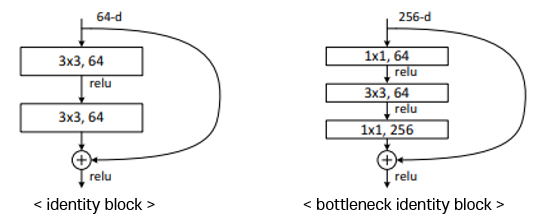

shortcut connection 시, 사용해야할 함수 : layers.Add()

In [ ]:
class IdentityBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, 3, stride, activation=True)
        self.conv2 = ConvBlock(out_channels, out_channels, 3, 1, activation=False)

        self.downsample = downsample
        self.final_activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.final_activation(out)
        return out

In [ ]:
class BottleneckBlock(nn.Module):
   """
   Bottleneck Identity Block - 1x1, 3x3, 1x1 conv로 구성
   """
   expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, 1, 1, activation=True)
        self.conv2 = ConvBlock(out_channels, out_channels, 3, stride, activation=True)
        self.conv3 = ConvBlock(out_channels, out_channels * self.expansion, 1, 1, activation=False)

        self.downsample = downsample
        self.final_activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        identity = x

        # 1x1 → 3x3 → 1x1 (bottleneck 구조)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)  # 마지막은 활성화 없음

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.final_activation(out)
        return out

## Resnet model class

- _make_layer:
    - _make_layer는 PyTorch 공식 구현에서 사용하는 방법으로, 레이어 그룹을 효율적으로 생성하기 위해 사용된다.

    - 필요성 : 반복 코드 재사용성을 위해

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # conv layer 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual block layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # 분류 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        # stride가 1이 아니거나 입력 채널과 출력 채널이 다르면 다운샘플링 필요
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU(x)
        x = self.maxpool(x)

        # Residual block layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # 분류
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
ResNet()